In [1]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

In [2]:
data = pd.read_excel("datatouse.xlsx")

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [4]:
def encode_text(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        outputs = model(**encoded_input)
    return outputs.last_hidden_state.mean(dim=1).numpy()

In [5]:
def decompose_query(query):
    return query.split(",")

In [6]:
# Calculate similarity between clinical features and nodes in the Knowledge Graph
def clinical_features_matching(features, knowledge_graph_nodes):
    feature_embeddings = encode_text(features)
    kg_embeddings = encode_text(knowledge_graph_nodes)
    similarities = cosine_similarity(feature_embeddings, kg_embeddings)
    return similarities

In [7]:
# Apply the indicator function to filter out irrelevant matches
def apply_indicator_function(similarities, threshold=0.7):
    valid_matches = (similarities > threshold).astype(int)
    return valid_matches

In [8]:
# Retrieve top-m most relevant matches
def retrieve_top_matches(similarities, m=3):
    top_matches = []
    for i in range(similarities.shape[0]):
        sorted_indices = np.argsort(similarities[i])[::-1]  # Sort by similarity in descending order
        top_m = sorted_indices[:m]
        top_matches.append(top_m)
    return top_matches

In [9]:
# Agglomerative Clustering (Hierarchical Clustering)
def agglomerative_clustering(data, num_clusters=8):
    embeddings = encode_text(data['object'].tolist())
    agg_clust = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    data['cluster'] = agg_clust.fit_predict(embeddings)
    return data, agg_clust

In [10]:
# Hierarchical aggregation (simple categorization based on clusters)
def hierarchical_aggregation(cluster_id):
    if cluster_id in [0, 1]:
        return 'Respiratory Diseases'
    else:
        return 'Cardiovascular Diseases'

In [11]:
# Create Disease Knowledge Graph
def create_disease_knowledge_graph(data):
    G = nx.Graph()
    for idx, row in data.iterrows():
        G.add_node(row['subject'], cluster=row['cluster'], description=row['object'])
    for cluster_id in range(num_clusters):
        cluster_nodes = data[data['cluster'] == cluster_id]['subject'].tolist()
        for i in range(len(cluster_nodes)):
            for j in range(i + 1, len(cluster_nodes)):
                G.add_edge(cluster_nodes[i], cluster_nodes[j])
    return G

In [12]:
# Upward Traversal (for finding closest disease subcategory)
def upward_traversal(ti, eL2j, graph):
    # This is a placeholder for actual traversal code
    return 0.85  # Return a dummy value representing the similarity

In [13]:
# Closest Disease Subcategory
def find_closest_disease_subcategory(ti, eL2j_candidates, graph, threshold=0.7):
    votes = {eL2j: 0 for eL2j in eL2j_candidates}
    for eL2j in eL2j_candidates:
        similarity = upward_traversal(ti, eL2j, graph)
        if similarity > threshold:
            votes[eL2j] += 1
    eL2s = max(votes, key=votes.get)
    return eL2s

In [14]:
# Diagnostic Differences Knowledge Graph K related to eL2s
def construct_diagnostic_differences_graph(graph, eL2s):
    K = set()
    neighbors = list(graph.neighbors(eL2s))
    for neighbor in neighbors:
        for subneighbor in graph.neighbors(neighbor):
            K.add((neighbor, subneighbor))
    return K

In [15]:
def visualize_disease_knowledge_graph(G, data):
    node_colors = []
    for node in G.nodes:
        matching_rows = data.loc[data['subject'] == node, 'cluster']
        if matching_rows.empty:
            node_colors.append(-1)
        else:
            node_colors.append(matching_rows.values[0])
    
    # Bây giờ node_colors có thể chứa cả -1 (hoặc cluster thực).
    # Bạn có thể định nghĩa thêm cách map -1 -> 1 màu riêng trong cmap.

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    

    nx.draw(
        G, pos,
        with_labels=True,
        node_size=1000,
        node_color=node_colors,
        cmap=plt.cm.viridis,  # Hoặc cmap tùy ý
        font_size=10,
        font_weight='bold'
    )
    plt.title("Disease Knowledge Graph (Disease Clustering) - Agglomerative Clustering")
    plt.show()


In [16]:
def match_query_to_kg_and_visualize(query, G, data, threshold=0.7, top_m=3):
    features = decompose_query(query)
    
    knowledge_graph_nodes = list(G.nodes)
    
    # Clinical Features Matching
    similarities = clinical_features_matching(features, knowledge_graph_nodes)
    valid_matches = apply_indicator_function(similarities, threshold)
    top_matches = retrieve_top_matches(similarities * valid_matches, m=top_m)

    print("Top matching clinical features in the knowledge graph:")
    for match in top_matches:
        print(match)
    
    # Closest Disease Subcategory
    closest_subcategory = find_closest_disease_subcategory(features[0], knowledge_graph_nodes, G)
    print(f"\nClosest Disease Subcategory: {closest_subcategory}")

    # Diagnostic Differences Knowledge Graph
    diagnostic_graph = construct_diagnostic_differences_graph(G, closest_subcategory)
    print(f"\nDiagnostic Differences Knowledge Graph (K({closest_subcategory})): {diagnostic_graph}")

    # Gọi hàm visualize với đối số data được truyền vào
    visualize_disease_knowledge_graph(G, data)


Top matching clinical features in the knowledge graph:
[62 15 28 27 26]
[10 62 15 28 27]
[62 15 28 27 26]

Closest Disease Subcategory: acute_copd_exacerbation_infection

Diagnostic Differences Knowledge Graph (K(acute_copd_exacerbation_infection)): {('spontaneous_rib_fracture', 'infectious_diseases'), ('myocarditis', 'allergic_sinusitis'), ('anemia', 'epiglottitis'), ('bronchiectasis', 'acute_pulmonary_edema'), ('pericarditis', 'anemia'), ('trauma_and_injury_related_conditions', 'boerhaave_syndrome'), ('larygospasm', 'spontaneous_pneumothorax'), ('larygospasm', 'possible_nstemi__stemi'), ('bronchospasm_acute_asthma_exacerbation', 'larygospasm'), ('guillain_barre_syndrome', 'bronchiectasis'), ('hiv_initial_infection', 'acute_rhinosinusitis'), ('scombroid_food_poisoning', 'myocarditis'), ('myocarditis', 'cluster_headache'), ('scombroid_food_poisoning', 'whooping_cough'), ('acute_dystonic_reactions', 'boerhaave'), ('boerhaave_syndrome', 'viral_pharyngitis'), ('spontaneous_rib_fracture', 

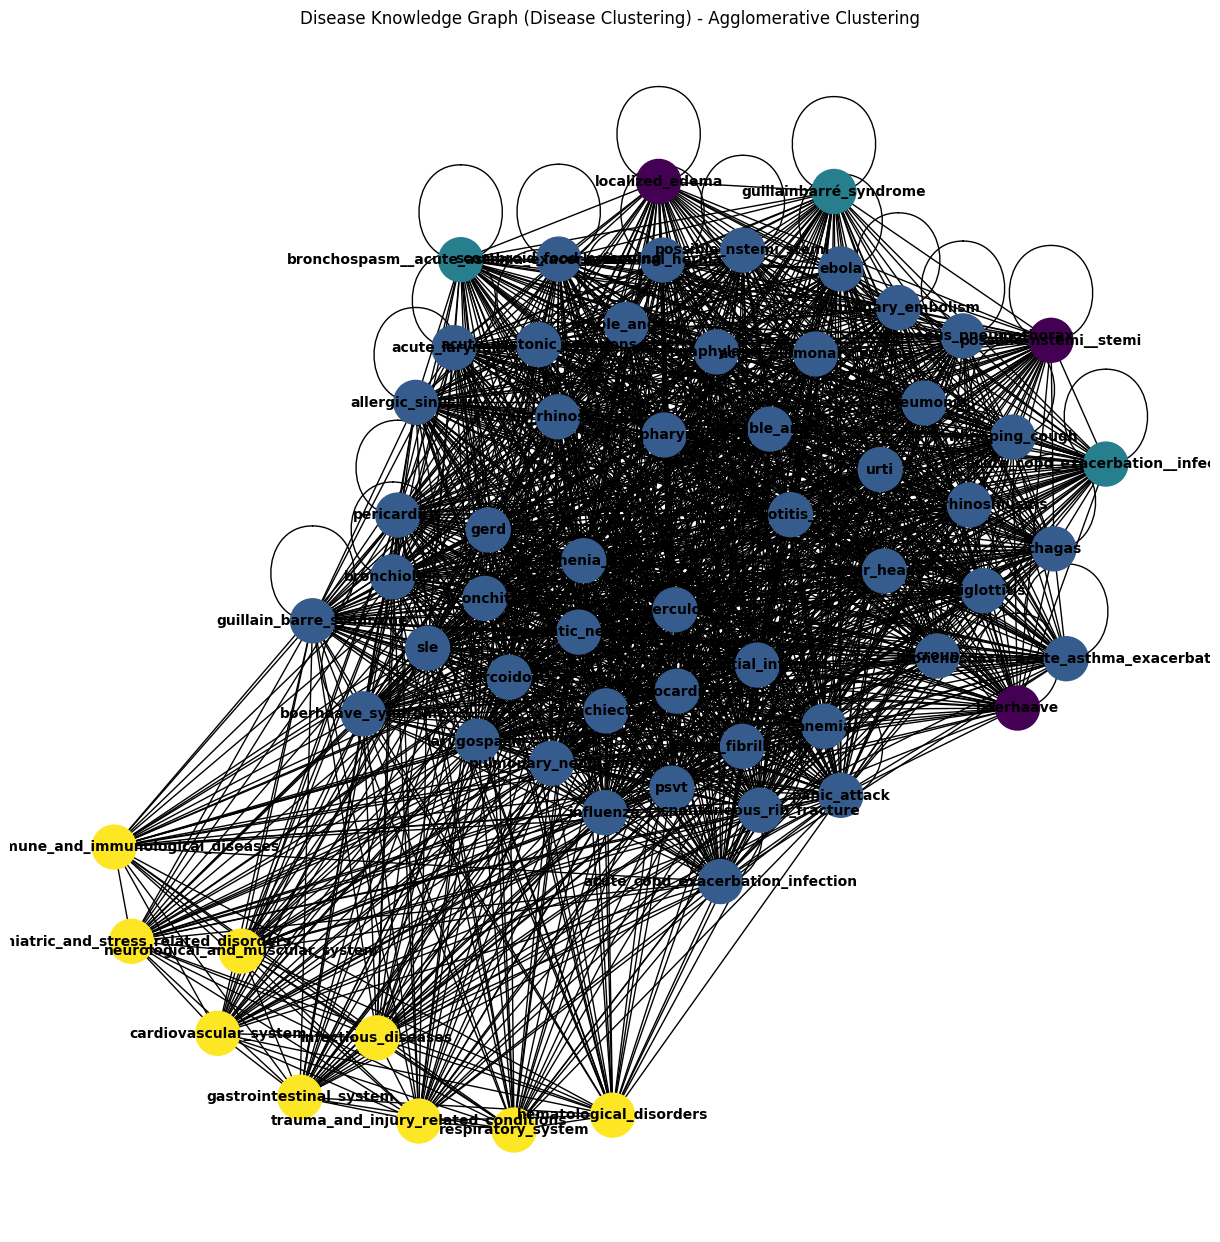

In [17]:
query = "shortness of breath, cough, wheezing"

num_clusters = 8
data, agg_clust = agglomerative_clustering(data, num_clusters=num_clusters) 

G = create_disease_knowledge_graph(data) 

match_query_to_kg_and_visualize(query, G, threshold=0.7, top_m=5)


In [18]:
def map_indices_to_names(top_matches, knowledge_graph_nodes):
    matched_names = []
    for match in top_matches:
        matched_names.append([knowledge_graph_nodes[i] for i in match])  
    return matched_names

query = "shortness of breath, cough, wheezing" 
knowledge_graph_nodes = list(G.nodes)  
similarities = clinical_features_matching(decompose_query(query), knowledge_graph_nodes)
valid_matches = apply_indicator_function(similarities, threshold=0.7)
top_matches = retrieve_top_matches(similarities * valid_matches, m=5)  

matched_names = map_indices_to_names(top_matches, list(G.nodes))

# The system retrueves n x m mathcing nodes in the G (Disease Knowledge Graph   )
print("Top matching clinical features in the knowledge graph:")
for match in matched_names:
    print(match)

Top matching clinical features in the knowledge graph:
['guillainbarré_syndrome', 'epiglottitis', 'sle', 'acute_dystonic_reactions', 'cluster_headache']
['whooping_cough', 'guillainbarré_syndrome', 'epiglottitis', 'sle', 'acute_dystonic_reactions']
['guillainbarré_syndrome', 'epiglottitis', 'sle', 'acute_dystonic_reactions', 'cluster_headache']


In [17]:
from openai import OpenAI

In [ ]:
client = OpenAI(
    # This is the default and can be omitted
    api_key = "",
)
    
def ask_gpt(prompt: str, system: str, model="gpt-4o-mini") -> str:
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system", 
                "content": system
            },
            {
                "role": "user",
                "content": prompt,
            }
        ],
        max_tokens=512
    )
    return response.choices[0].message.content

In [19]:
def augment_knowledge_graph_with_llm(G, disease_nodes):
    """
    Gọi ChatGPT cho từng disease node để lấy về những mối quan hệ (edges) mới,
    giúp phân biệt disease này với những disease có biểu hiện tương tự.
    Sau đó thêm các edges này vào graph G.
    """
    new_edges = []
    
    for disease in disease_nodes:
        # Nội dung hiển thị cho "role": "system"
        system_prompt = (
            "Bạn là một chuyên gia y tế. "
            "Hãy trả về danh sách các quan hệ hoặc tri thức y khoa giúp phân biệt các bệnh có triệu chứng giống nhau."
        )

        # Nội dung hiển thị cho "role": "user"
        user_prompt = f"""
        Given the disease '{disease}', list additional relevant relationships or knowledge edges 
        that can help distinguish it from other diseases with similar clinical manifestations.
        Provide each relationship in the form:
        subject,relationship,object

        Example:
        lumbar_spondylosis,has_symptom,stiffness_or_pain_in_the_lower_back
        """

        try:
            text_output = ask_gpt(
                prompt=user_prompt,
                system=system_prompt,
                model="gpt-4o-mini"  
            )
            
            lines = text_output.split("\n")
            
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                parts = line.split(",")
                
                if len(parts) == 3:
                    subject = parts[0].strip()
                    relationship = parts[1].strip()
                    obj = parts[2].strip()
                    
                    if subject not in G.nodes:
                        G.add_node(subject)
                    if obj not in G.nodes:
                        G.add_node(obj)
                    
                    G.add_edge(subject, obj, relationship=relationship)
                    new_edges.append((subject, relationship, obj))
                    
        except Exception as e:
            print(f"Lỗi khi gọi ChatGPT cho disease {disease}: {e}")

    return new_edges

Top matching clinical features in the knowledge graph:
[62 15 28 27 26]
[10 62 15 28 27]
[62 15 28 27 26]

Closest Disease Subcategory: acute_copd_exacerbation_infection

Diagnostic Differences Knowledge Graph (K(acute_copd_exacerbation_infection)): {('trauma_and_injury_related_conditions', 'pancreatic_neoplasm'), ('bronchiectasis', 'infectious_diseases'), ('unstable_angina', 'boerhaave_syndrome'), ('acute_otitis_media', 'acute_rhinosinusitis'), ('unstable_angina', 'urti'), ('pericarditis', 'acute_rhinosinusitis'), ('bronchiolitis', 'atrial_fibrillation'), ('bronchitis', 'pericarditis'), ('ebola', 'cluster_headache'), ('unstable_angina', 'pancreatic_neoplasm'), ('acute_otitis_media', 'hiv_initial_infection'), ('acute_laryngitis', 'boerhaave_syndrome'), ('bronchospasm_acute_asthma_exacerbation', 'spontaneous_pneumothorax'), ('acute_laryngitis', 'urti'), ('myocarditis', 'myasthenia_gravis'), ('bronchiectasis', 'inguinal_hernia'), ('pericarditis', 'hiv_initial_infection'), ('inguinal_hern

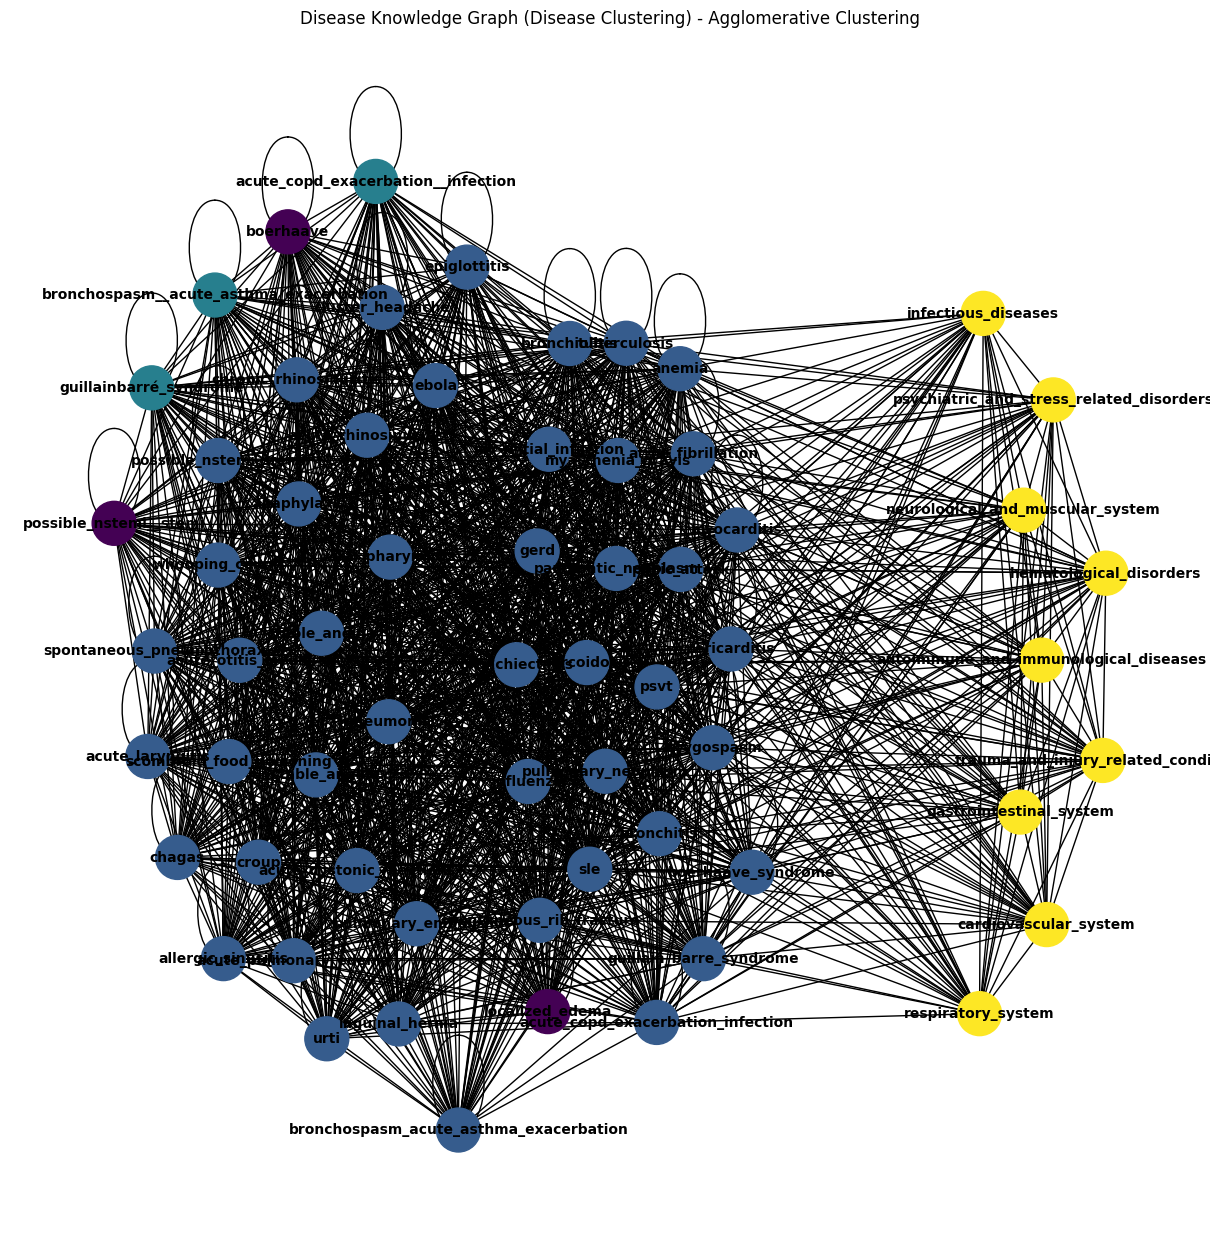


Newly added edges from ChatGPT augmentation:
('1. acute_copd_exacerbation_infection', 'has_symptom', 'increased_cough_or_sputum_production')
('2. acute_copd_exacerbation_infection', 'has_trigger', 'respiratory_infections')
('3. acute_copd_exacerbation_infection', 'has_symptom', 'wheezing_or_breathlessness')
('4. acute_copd_exacerbation_infection', 'has_symptom', 'fever_or_malaise')
('5. acute_copd_exacerbation_infection', 'distinguished_from', 'pneumonia_by_radiographic_findings')
('6. acute_copd_exacerbation_infection', 'distinguished_from', 'heart_failure_by_echocardiography')
('7. acute_copd_exacerbation_infection', 'can_lead_to', 'pulmonary_hyperinflation')
('8. acute_copd_exacerbation_infection', 'is_a_type_of', 'COPD_exacerbation')
('9. COPD', 'has_risk_factor', 'smoking')
('10. COPD', 'has_related_condition', 'bronchiectasis')
('1. bronchiectasis', 'has_symptom', 'chronic_cough')
('2. bronchiectasis', 'has_symptom', 'sputum_production')
('3. bronchiectasis', 'has_symptom', 'hem

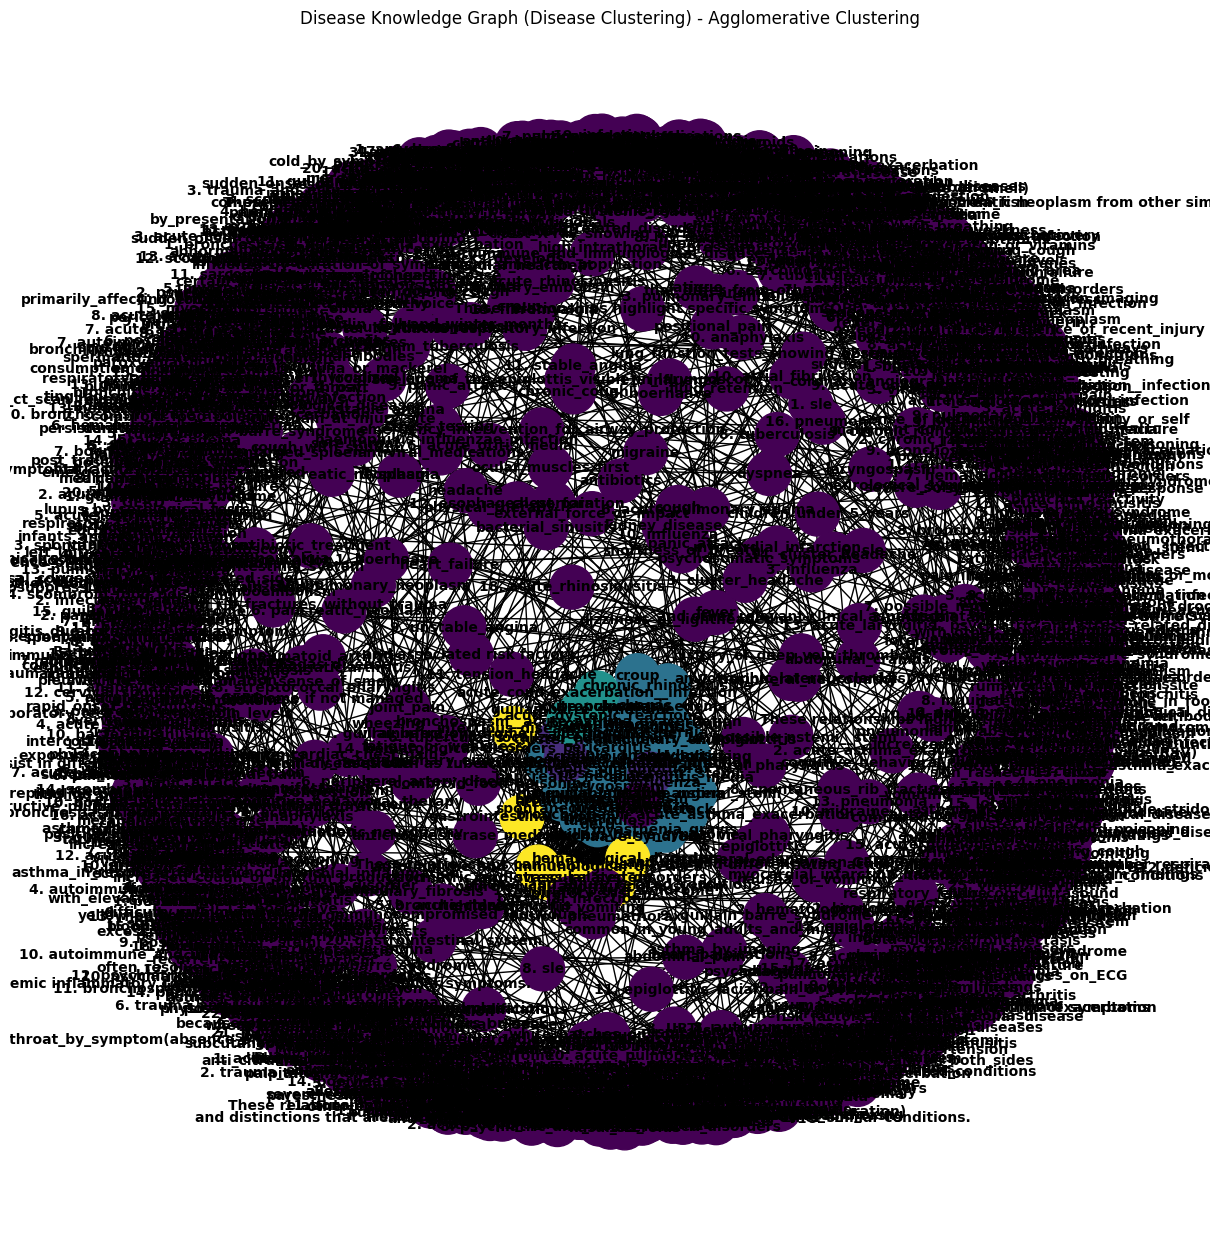

In [20]:
if __name__ == "__main__":
    data = pd.read_excel("datatouse.xlsx")
    
    num_clusters = 8
    data, agg_clust = agglomerative_clustering(data, num_clusters=num_clusters)
    
    G = create_disease_knowledge_graph(data)
    
    query = "shortness of breath, cough, wheezing"
    
    match_query_to_kg_and_visualize(query, G, data, threshold=0.7, top_m=5)
    
    disease_nodes = list(G.nodes)
    
    new_edges = augment_knowledge_graph_with_llm(G, disease_nodes)
    
    print("\nNewly added edges from ChatGPT augmentation:")
    for edge in new_edges:
        print(edge)
    
    # Gọi visualize với đối số data
    visualize_disease_knowledge_graph(G, data)


In [21]:
def save_knowledge_graph_to_text(G, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("Danh sách Nodes:\n")
        for node, attr in G.nodes(data=True):
            f.write(f"{node}: {attr}\n")
        
        f.write("\nDanh sách Edges:\n")
        for u, v, attr in G.edges(data=True):
            f.write(f"{u} -- {v}: {attr}\n")

save_knowledge_graph_to_text(G, "Diagnostic_Knowledge_Graph.txt")